In [18]:
# Импорты
import torch
import torch.nn as nn
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Константы
SEQ_LEN = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {DEVICE}")

Используем устройство: cuda


In [19]:
dataset = StudentPerformanceDataset(db_path="school.db", seq_len=8)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

print(f"Количество последовательностей: {len(dataset)}")
print(f"Пример батча:")
for batch in dataloader:
    print("subject.shape:", batch["subject"].shape)
    print("numeric.shape:", batch["numeric"].shape)
    print("target.shape:", batch["target"].shape)
    break

✅ Загружено 300000 обучающих последовательностей
Количество последовательностей: 300000
Пример батча:
subject.shape: torch.Size([64, 8])
numeric.shape: torch.Size([64, 8, 3])
target.shape: torch.Size([64])


In [11]:
model = StudentTransformer(
    num_subjects=5,
    num_absence_reasons=6,   # ← обязательно 6!
    num_club_types=2,
    numeric_features=3,
    embed_dim=64,
    num_heads=4,
    num_layers=2,
    pred_type="binary"
)

print("✅ Модель создана")
print("Число параметров:", sum(p.numel() for p in model.parameters()))

✅ Модель создана
Число параметров: 565633


In [20]:
# Сначала загрузи данные
from data_loader import StudentPerformanceDataset, collate_fn
from torch.utils.data import DataLoader

train_dataset = StudentPerformanceDataset(split="train")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# Затем обучение
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
losses = []

for epoch in range(10):  # 10 эпох
    epoch_loss = 0
    for i, batch in enumerate(train_loader):  # ← Используем train_loader!
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch["target"])
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        if i % 50 == 0:
            print(f"Эпоха {epoch+1}, шаг {i}, loss: {loss.item():.4f}")
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Средний loss за эпоху: {avg_loss:.4f}")

# Сохраняем модель
torch.save(model.state_dict(), "student_transformer.pth")
print("✅ Модель сохранена")

TypeError: StudentPerformanceDataset.__init__() got an unexpected keyword argument 'split'

In [ ]:
# Загрузка тестовых данных
test_dataset = StudentPerformanceDataset(split="test")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Оценка
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(batch["target"].cpu().numpy())

# Метрики
preds_binary = (np.array(all_preds) > 0.5).astype(int)
targets = np.array(all_targets)

print(f"Accuracy: {accuracy_score(targets, preds_binary):.4f}")
print(f"F1-score: {f1_score(targets, preds_binary):.4f}")
print(f"AUC-ROC:  {roc_auc_score(targets, all_preds):.4f}")

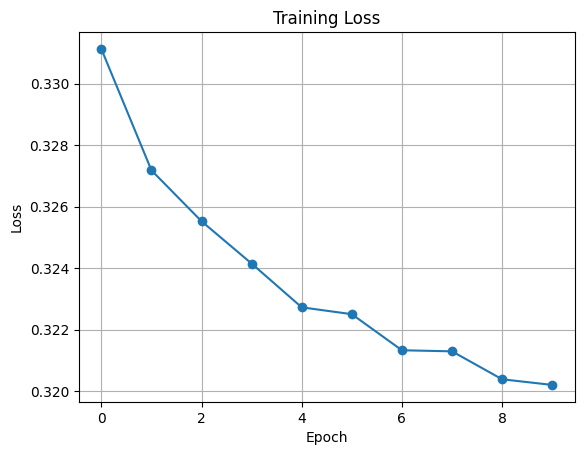

In [16]:
plt.plot(losses, marker='o')  # ← добавили маркер
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# === Ячейка: Пример предсказания (инференс) ===

# 1. Загрузим сохранённую модель
model.load_state_dict(torch.load("student_transformer.pth", map_location=device))
model.eval()

# 2. Подготовим пример данных (8 недель по математике)
# Формат: [неделя 1, неделя 2, ..., неделя 8]
example_data = {
    "subject": "math",
    "grades": [4.5, 4.0, 4.0, 3.5, 3.0, 3.0, 2.5, 3.0],        # оценки падают
    "attendance": [1, 1, 1, 0, 0, 1, 1, 1],                      # пропуски на 4-5 неделях
    "club_attended": [1, 1, 0, 0, 0, 0, 0, 0],                   # перестал ходить в кружок
    "absence_reasons": [None, None, None, "illness", "illness", None, None, None]
}

# 3. Преобразуем в формат модели
SUBJECT_TO_ID = {"math":0, "russian":1, "physics":2, "literature":3, "biology":4}
REASON_TO_ID = {None:0, "illness":1, "competition":2, "family":3, "other":4, "camp":5}

subject_id = SUBJECT_TO_ID[example_data["subject"]]
absence_ids = [REASON_TO_ID.get(r, 4) for r in example_data["absence_reasons"]]
numeric = np.stack([
    example_data["grades"],
    example_data["attendance"],
    example_data["club_attended"]
], axis=1).astype(np.float32)

# Создаём батч из одного примера
batch = {
    "subject": torch.tensor([[subject_id] * 8]),      # [1, 8]
    "absence": torch.tensor([absence_ids]),           # [1, 8]
    "club": torch.tensor([example_data["club_attended"]]),  # [1, 8]
    "numeric": torch.tensor([numeric])                # [1, 8, 3]
}

# 4. Предсказание
with torch.no_grad():
    prob = model({k: v.to(device) for k, v in batch.items()}).item()

# 5. Вывод
print(f"🎓 Прогноз для ученика по предмету '{example_data['subject']}':")
print(f"   Вероятность снижения успеваемости: {prob:.2%}")
if prob > 0.5:
    print("   ⚠️  Рекомендуется педагогическое вмешательство!")
else:
    print("   ✅ Риск низкий.")